In [ ]:
from IPython import get_ipython
from IPython.display import display
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

# Set a maximum number of employees
MAX_EMPLOYEES = 3

In [ ]:
# Mount Drive
drive.mount('/content/drive')

# Paths to your datasets
task_data_path = '/content/drive/MyDrive/Skripsi/Resources/task_test.csv'
employee_data_path = '/content/drive/MyDrive/Skripsi/Resources/employee_test.csv'

# Load the datasets
df_tasks_original = pd.read_csv(task_data_path)
df_employees_original = pd.read_csv(employee_data_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Ensure employees count is always MAX_EMPLOYEES
if len(df_employees_original) < MAX_EMPLOYEES:
    # Pad with dummy employees
    num_to_add = MAX_EMPLOYEES - len(df_employees_original)
    new_rows = pd.DataFrame([{
        'employee_id': f'Dummy {i+1}',
        'Role': 'Dummy',
        'Mathematics.Linear Algebra': 1,
        'Mathematics.Differential Equations': 1,
        'Mathematics.Optimization Technique': 1
    } for i in range(num_to_add)])
    df_employees_original = pd.concat([df_employees_original, new_rows], ignore_index=True)
elif len(df_employees_original) > MAX_EMPLOYEES:
    # Truncate
    df_employees_original = df_employees_original.iloc[:MAX_EMPLOYEES]

df_employees = df_employees_original.reset_index(drop=True)
df_tasks = df_tasks_original.reset_index(drop=True)

In [ ]:
class TaskAssignmentEnv:
    def __init__(self, tasks, employees, max_workload=20, alpha=0.5):
        self.tasks = tasks
        self.employees = employees
        self.max_workload = max_workload
        self.alpha = alpha
        self.num_tasks = len(tasks)
        self.num_employees = len(employees)

        self.state = np.zeros((self.num_tasks, self.num_employees)) # Task assignments
        self.workloads = np.zeros(self.num_employees)

        # Precompute worst possible WED for normalization
        self.max_skill = tasks.iloc[:, 3:].max().values
        self.min_skill = employees.iloc[:, 2:].min().values
        self.max_wed = self._compute_wed(self.max_skill, self.min_skill)


    def valid_actions(self, task_idx):
        valid = []
        for i in range(self.num_employees):
            # Skip if this employee is a dummy
            if 'Dummy' in self.employees.iloc[i]['Role']:
                continue
            # Check workload constraint
            if self.workloads[i] + self.tasks.iloc[task_idx]['story_points'] <= self.max_workload:
                valid.append(i)
        return valid

    def reset(self):
        self.state = np.zeros((self.num_tasks, self.num_employees))
        self.workloads = np.zeros(self.num_employees)
        return self.state

    def step(self, task_idx, employee_idx):
        task = self.tasks.iloc[task_idx]
        employee = self.employees.iloc[employee_idx]
        # Calculate Weighted Euclidean Distance (WED)
        task_skills = task[3:].values
        employee_skills = employee[2:].values
        weights = 1 / (1 + self.alpha * np.maximum(0, employee_skills - task_skills))
        wed = np.sqrt(np.sum(weights * (employee_skills - task_skills) ** 2))

        # Normalize similarity score
        similarity_score = 1 - wed / self.max_wed

        # Update State
        self.state[task_idx, employee_idx] = 1
        self.workloads[employee_idx] += task['story_points']

        # Calculate Reward
        std_workload = np.std(self.workloads)
        workload_balance_score = 1 / (1 + std_workload) # Normalize workload balance

        # Weighted reward (similarity_score is more important)
        reward = 0.8 * similarity_score + 0.2 * workload_balance_score

        # Check if workload exceeds max
        done = np.all(self.state.sum(axis=1)) or np.any(self.workloads > self.max_workload)

        return self.state, reward, done

    def valid_actions(self, task_idx):
        # Ensure task can only be assigned if it doesn't exceed max workload
        return [i for i in range(self.num_employees)
                if self.workloads[i] + self.tasks.iloc[task_idx]['story_points'] <= self.max_workload]

    def _compute_wed(self, task_skills, employee_skills):
        weights = 1 / (1 + self.alpha * np.maximum(0, employee_skills - task_skills))
        return np.sqrt(np.sum(weights * (employee_skills - task_skills) ** 2))


In [ ]:
class PPOAgent(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(PPOAgent, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.actor = nn.Linear(hidden_dim, action_dim)
        self.critic = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.fc(x)
        return self.actor(x), self.critic(x)

    def get_action(self, state, valid_actions):
        logits, _ = self.forward(state)
        probs = torch.softmax(logits, dim=-1)
        # Handle the case when valid_actions is empty
        if not valid_actions:
            # Return a default action
            return 0, torch.tensor(0.0)
        probs = probs[valid_actions] # Mask invalid actions
        if probs.numel() == 0:
            return 0, torch.tensor(0.0)
        action_dist = Categorical(probs)
        action = action_dist.sample()
        return valid_actions[action.item()], action_dist.log_prob(action)

In [ ]:
class PPO:
    def __init__(self, agent, lr=3e-4, gamma=0.99, eps_clip=0.2, k_epochs=4):
        self.agent = agent
        self.optimizer = optim.Adam(agent.parameters(), lr=lr)
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.k_epochs = k_epochs
        self.mse_loss = nn.MSELoss()

    def compute_returns(self, rewards, dones, next_value):
        returns = []
        R = next_value
        for reward, done in zip(reversed(rewards), reversed(dones)):
            R = reward + self.gamma * R * (1 - done)
            returns.insert(0, R)
        return returns

    def train(self, states, actions, log_probs, rewards, dones, next_value):
        returns = self.compute_returns(rewards, dones, next_value)
        returns = torch.tensor(returns).float()
        states = torch.tensor(states).float()
        actions = torch.tensor(actions).long()
        log_probs = torch.tensor(log_probs).float()

        for _ in range(self.k_epochs):
            logits, state_values = self.agent(states)
            action_dist = Categorical(torch.softmax(logits, dim=-1))
            new_log_probs = action_dist.log_prob(actions)

            # Policy Loss
            ratios = torch.exp(new_log_probs - log_probs)
            advantages = returns - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
            policy_loss = -torch.min(surr1, surr2).mean()

            # Value Loss
            value_loss = self.mse_loss(state_values, returns)

            # Total Loss
            loss = policy_loss + 0.5 * value_loss
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

In [ ]:
# Create environment with fixed employees
env = TaskAssignmentEnv(df_tasks, df_employees)
state_dim = env.state.size
action_dim = MAX_EMPLOYEES

agent = PPOAgent(state_dim, action_dim)
ppo = PPO(agent)

num_episodes = 1000
task_assignments = {}
convergence_threshold = 1e-2
convergence_patience = 100
reward_history = []
similarity_scores = []
workload_distributions = []
std_workloads = []

for episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0
    done = False
    task_idx = 0
    episode_similarity_scores = []
    episode_workload = np.zeros(env.num_employees)
    task_assignments_episode = {}  # store assignments for this episode if needed

    while not done:
        state_tensor = torch.tensor(state.flatten(), dtype=torch.float32)
        valid_actions = env.valid_actions(task_idx=task_idx)
        action, log_prob = agent.get_action(state_tensor, valid_actions)
        next_state, reward, done = env.step(task_idx=task_idx, employee_idx=action)

        # Store task assignment for this episode if you need it
        task_assignments_episode[env.tasks.iloc[task_idx]['task_id']] = env.employees.iloc[action]['employee_id']

        # Similarity and workload tracking...
        task = env.tasks.iloc[task_idx]
        employee = env.employees.iloc[action]
        task_skills = task[3:].values
        employee_skills = employee[2:].values
        weights = 1 / (1 + env.alpha * np.maximum(0, employee_skills - task_skills))
        distance = np.sqrt(np.sum(weights * (employee_skills - task_skills) ** 2))
        episode_similarity_scores.append(distance)
        episode_workload[action] += task['story_points']

        # Train PPO
        ppo.train(state_tensor.unsqueeze(0), [action], [log_prob], [reward], [done], next_value=0)
        state = next_state
        episode_reward += reward

        if np.any(env.state[task_idx]):
            task_idx += 1
        if task_idx >= env.num_tasks:
            done = True

    similarity_scores.append(episode_similarity_scores)
    workload_distributions.append(episode_workload)
    std_workloads.append(np.std(episode_workload))
    reward_history.append(episode_reward)

    # Only print minimal info here
    print(f"Episode {episode}, Reward: {episode_reward}")

    # Check for convergence
    if len(reward_history) > convergence_patience:
        recent_rewards = reward_history[-convergence_patience:]
        if max(recent_rewards) - min(recent_rewards) < convergence_threshold:
            print(f"Convergence achieved at episode {episode}. Stopping training.")
            break

# After training completes, print final task assignment strategy if needed
print("\nFinal Task Assignment Strategy:")
for t_id, e_id in task_assignments_episode.items():
    print(f"Task {t_id} assigned to Employee {e_id}")

<ipython-input-23-c79fe817ddc4>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  states = torch.tensor(states).float()
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 0, Reward: 2.3254112557793496
Episode 1, Reward: 2.37767082590612
Episode 2, Reward: 3.638744589112683
Episode 3, Reward: 1.5421139823670962
Episode 4, Reward: 3.720808080808081
Episode 5, Reward: 3.0238383838383838
Episode 6, Reward: 2.37767082590612
Episode 7, Reward: 2.1065584268115405
Episode 8, Reward: 3.1909588217382514
Episode 9, Reward: 1.9489682395894468
Episode 10, Reward: 2.5153547942112957
Episode 11, Reward: 3.1909588217382514
Episode 12, Reward: 3.088864454485662
Episode 13, Reward: 3.088864454485662
Episode 14, Reward: 3.0212987016667956
Episode 15, Reward: 2.5153547942112957
Episode 16, Reward: 3.088864454485662
Episode 17, Reward: 3.638744589112683
Episode 18, Reward: 3.088864454485662
Episode 19, Reward: 3.1909588217382514
Episode 20, Reward: 3.088864454485662
Episode 21, Reward: 3.088864454485662
Episode 22, Reward: 3.088864454485662
Episode 23, Reward: 3.088864454485662
Episode 24, Reward: 3.088864454485662
Episode 25, Reward: 3.088864454485662
Episode 26, R

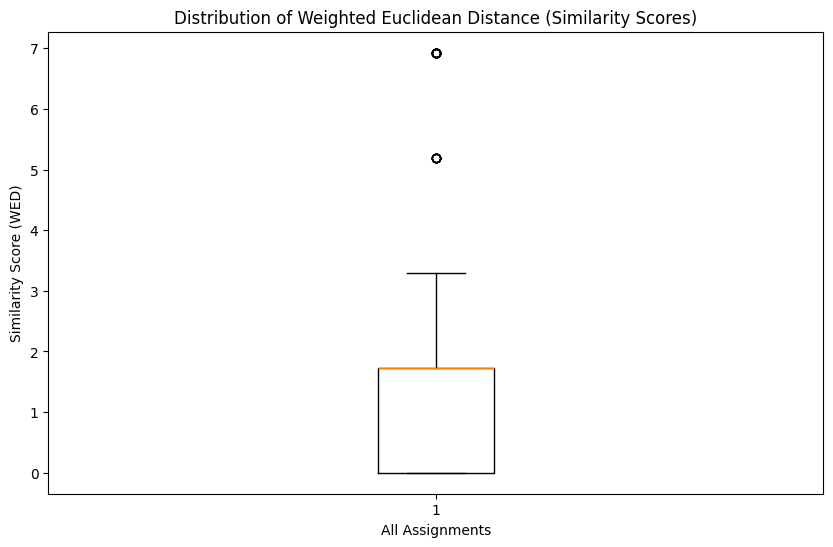

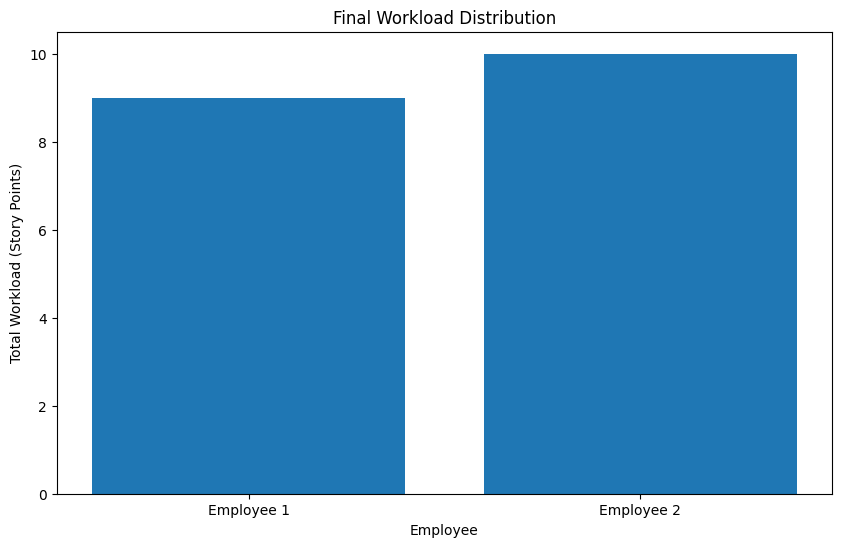

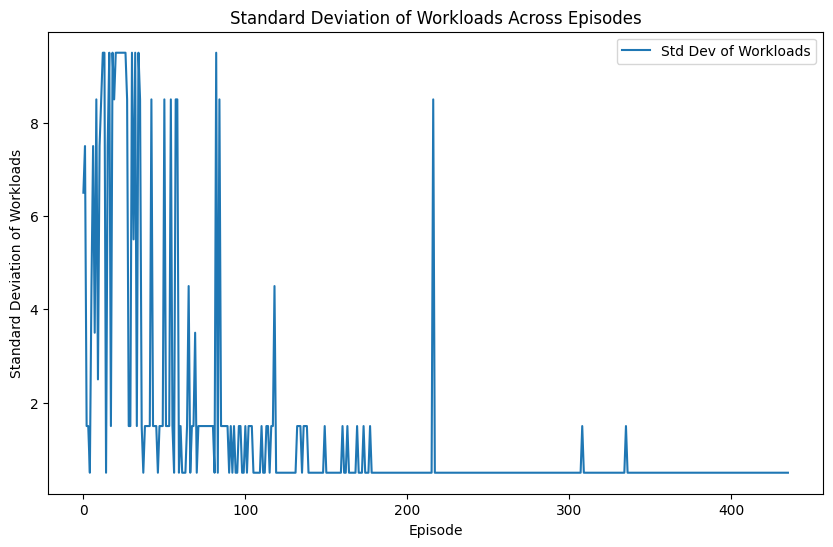

In [ ]:
# Similarity Scores Boxplot
plt.figure(figsize=(10, 6))
all_similarity_scores = [score for episode_scores in similarity_scores for score in episode_scores]
plt.boxplot(all_similarity_scores)
plt.title('Distribution of Weighted Euclidean Distance (Similarity Scores)')
plt.ylabel('Similarity Score (WED)')
plt.xlabel('All Assignments')
plt.show()

# Workload Distribution Bar Chart
final_workloads = workload_distributions[-1]  # Workload distribution from the last episode
plt.figure(figsize=(10, 6))
plt.bar(range(len(final_workloads)), final_workloads, tick_label=[f'Employee {i+1}' for i in range(len(final_workloads))])
plt.title('Final Workload Distribution')
plt.xlabel('Employee')
plt.ylabel('Total Workload (Story Points)')
plt.show()

# Standard Deviation of Workloads Line Plot
plt.figure(figsize=(10, 6))
plt.plot(std_workloads, label='Std Dev of Workloads')
plt.title('Standard Deviation of Workloads Across Episodes')
plt.xlabel('Episode')
plt.ylabel('Standard Deviation of Workloads')
plt.legend()
plt.show()


In [26]:
# Save the trained model
torch.save(agent.state_dict(), '/content/drive/MyDrive/Skripsi/Resources/trained_ppo_agent.pth')

In [ ]:
# Testing on new dataset with same approach
new_task_data_path = '/content/drive/MyDrive/Skripsi/Resources/task_test2.csv'
new_employee_data_path = '/content/drive/MyDrive/Skripsi/Resources/employee_test2.csv'

new_df_tasks_original = pd.read_csv(new_task_data_path)
new_df_employees_original = pd.read_csv(new_employee_data_path)

# Adjust employees again
if len(new_df_employees_original) < MAX_EMPLOYEES:
    num_to_add = MAX_EMPLOYEES - len(new_df_employees_original)
    new_rows = pd.DataFrame([{
        'employee_id': f'Dummy {i+1}',
        'Role': 'Dummy',
        'Mathematics.Linear Algebra': 1,
        'Mathematics.Differential Equations': 1,
        'Mathematics.Optimization Technique': 1
    } for i in range(num_to_add)])
    new_df_employees_original = pd.concat([new_df_employees_original, new_rows], ignore_index=True)
elif len(new_df_employees_original) > MAX_EMPLOYEES:
    new_df_employees_original = new_df_employees_original.iloc[:MAX_EMPLOYEES]

new_df_employees = new_df_employees_original.reset_index(drop=True)
new_df_tasks = new_df_tasks_original.reset_index(drop=True)

new_env = TaskAssignmentEnv(new_df_tasks, new_df_employees)

<ipython-input-30-534910df3b5f>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load('/content/drive/MyDrive/Skripsi/Resources/trained_ppo_agent.pth

PPOAgent(
  (fc): Sequential(
    (0): Linear(in_features=15, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
  )
  (actor): Linear(in_features=128, out_features=2, bias=True)
  (critic): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
# Recreate agent for new environment state dimension (should match)
new_state_dim = new_env.state.size
new_agent = PPOAgent(new_state_dim, MAX_EMPLOYEES)
pretrained_dict = torch.load('/content/drive/MyDrive/Skripsi/Resources/trained_ppo_agent.pth')
model_dict = new_agent.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and v.size() == model_dict[k].size()}
model_dict.update(pretrained_dict)
new_agent.load_state_dict(model_dict)
new_agent.eval()

task_assignments = {}
state = new_env.reset()
done = False
task_idx = 0

while not done:
    state_tensor = torch.tensor(state.flatten(), dtype=torch.float32)
    valid_actions = new_env.valid_actions(task_idx=task_idx)
    action, _ = new_agent.get_action(state_tensor, valid_actions)
    next_state, _, done = new_env.step(task_idx=task_idx, employee_idx=action)
    task_assignments[new_df_tasks.iloc[task_idx]['task_id']] = new_df_employees.iloc[action]['employee_id']
    state = next_state
    if np.any(new_env.state[task_idx]):
        task_idx += 1
    if task_idx >= new_env.num_tasks:
        done = True

print("\nTask Assignment Strategy for New Dataset:")
for task_id, employee_id in task_assignments.items():
    print(f"Task {task_id} assigned to Employee {employee_id}")